# Import Library

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter


# Load the data for inflation
https://data.bls.gov/timeseries/CUUR0000SA0L1E?output_view=pct_12mths

In [4]:
cpi_df = pd.read_excel('./SeriesReport-20250411111756_540f2c.xlsx', skiprows= 11)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
# Calculate annual average inflation rate
cpi_df['Inflation_Rate'] = (cpi_df['HALF1'] + cpi_df['HALF2']) / 2

# Initialize CPI Index with 2024 as base (100)
cpi_index = [None] * len(cpi_df)
base_year_idx = cpi_df[cpi_df['Year'] == 2024].index[0]
cpi_index[base_year_idx] = 100.0

# Backward calculation (2023 → 2015)
for i in range(base_year_idx - 1, -1, -1):
    cpi_index[i] = cpi_index[i + 1] / (1 + cpi_df.loc[i, 'Inflation_Rate'] / 100)


# Forward calculation (2025)
if 2025 in cpi_df['Year'].values:
    jan_2025_inflation = cpi_df.loc[cpi_df['Year'] == 2025, 'Jan'].values[0]
    cpi_index[base_year_idx + 1] = cpi_index[base_year_idx] * (1 + jan_2025_inflation / 100)

cpi_df['CPI_Index'] = cpi_index

cpi_df = cpi_df[['Year', 'CPI_Index']]

# Load the data

In [6]:
df_rfm = pd.read_excel('./output.xlsx')
df_rfm = df_rfm.rename(columns={'id': 'ID'})

In [7]:
df_transactions = pd.read_excel('./data/all_transactions.xlsx')
df_transactions = df_transactions.rename(columns={'Revenue Amount': 'Revenue', 'Account Number': 'ID'})

In [8]:
df = df_transactions.merge(df_rfm, on='ID', how='inner')
df = df[(df['Type'] != 'Soft Credit') & (df['Revenue'] > 0) & (df['Date'] >= '2015-01-01' ) & (df['Date'] < '2025-02-01')]
df['Year'] = df['Date'].dt.year

In [9]:
# Merge CPI Index with revenue data
df = df.merge(cpi_df, on='Year', how='left')

# Delete Year column
df = df.drop(columns=['Year'])

# Calculate inflation-adjusted revenue (2024 dollars)
df['Real_Revenue'] = (df['Revenue'] / df['CPI_Index']) * 100

In [10]:
df.nunique()

ID                  2523
Date                2018
Revenue              528
Type                   3
Fund                   6
Campaign              28
Appeal                34
Primary City         455
Primary State         49
Primary ZIP Code    1293
Monetary             840
Recency              790
Frequency             59
Cluster                3
R                      4
F                      3
M                      4
RFM_Segment           46
RFM_Score             10
Segment                5
CPI_Index             11
Real_Revenue         987
dtype: int64

# Time Series with Inflation Account


In [11]:
df['Year_Month'] = df['Date'].dt.to_period('M') 
df

,ID,Date,Revenue,Type,Fund,Campaign,Appeal,Primary City,Primary State,Primary ZIP Code,...,Cluster,R,F,M,RFM_Segment,RFM_Score,Segment,CPI_Index,Real_Revenue,Year_Month
0,10443,2025-01-30,50.00,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,BTJ Website,DUBLIN,OH,43016,...,0,4,4,4,444,12,Star Donors,103.300000,48.402711,2025-01
1,9735,2025-01-30,24.23,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,BTJ Website,Columbus,OH,43235,...,0,4,4,4,444,12,Star Donors,103.300000,23.455954,2025-01
2,9722,2025-01-29,26.31,Donation,Unrestricted,2025 Celebrating A Decade of Hope and Healing,NaN,Saint James City,FL,33956,...,0,4,4,4,444,12,Star Donors,103.300000,25.469506,2025-01
3,825,2025-01-29,52.30,Recurring Donation Payment,Unrestricted,2025 Celebrating A Decade of Hope and Healing,NaN,Saint James City,FL,33956,...,0,4,4,4,444,12,Star Donors,103.300000,50.629235,2025-01
4,250,2025-01-28,25.87,Recurring Donation Payment,Unrestricted,NaN,NaN,Columbus,OH,43235,...,0,4,4,4,444,12,Star Donors,103.300000,25.043562,2025-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8926,296,2015-01-01,100.00,Donation,Unrestricted,NaN,NaN,Columbus,OH,43220-4325,...,2,1,1,2,112,4,Inactive Donors,77.161149,129.598899,2015-01
8927,163,2015-01-01,50.00,Donation,Unrestricted,NaN,NaN,Powell,OH,43065,...,0,4,4,4,444,12,Star Donors,77.161149,64.799449,2015-01
8928,147,2015-01-01,500.00,Donation,Unrestricted,NaN,NaN,NaN,NaN,NaN,...,2,1,1,4,114,6,Inactive Donors,77.161149,647.994494,2015-01
8929,8035,2015-01-01,100.00,Donation,Unrestricted,NaN,NaN,Columbus,OH,43221,...,0,2,4,4,244,10,Emerging Partners,77.161149,129.598899,2015-01


## STL Decomposition

In [127]:
# Group and sum revenue
df_decomp = df[['Real_Revenue', 'Date']].resample('M', on='Date').sum().reset_index()
df_decomp = df_decomp[(df_decomp['Date'] > '2018-01-01') & (df_decomp['Date'] < '2025-02-01')]
df_decomp

,Date,Real_Revenue
36,2018-01-31,1196.160178
37,2018-02-28,330.221517
38,2018-03-31,5654.126197
39,2018-04-30,28460.875272
40,2018-05-31,40132.371336
...,...,...
116,2024-09-30,62606.320000
117,2024-10-31,278184.070000
118,2024-11-30,26970.690000
119,2024-12-31,116619.350000


In [128]:
# Make sure it's a Series and the index is datetime
df_decomp = df_decomp.rename(columns={'Real_Revenue': 'Real Revenue'})
df_decomp = df_decomp.set_index("Date")
df_decomp = df_decomp['Real Revenue']

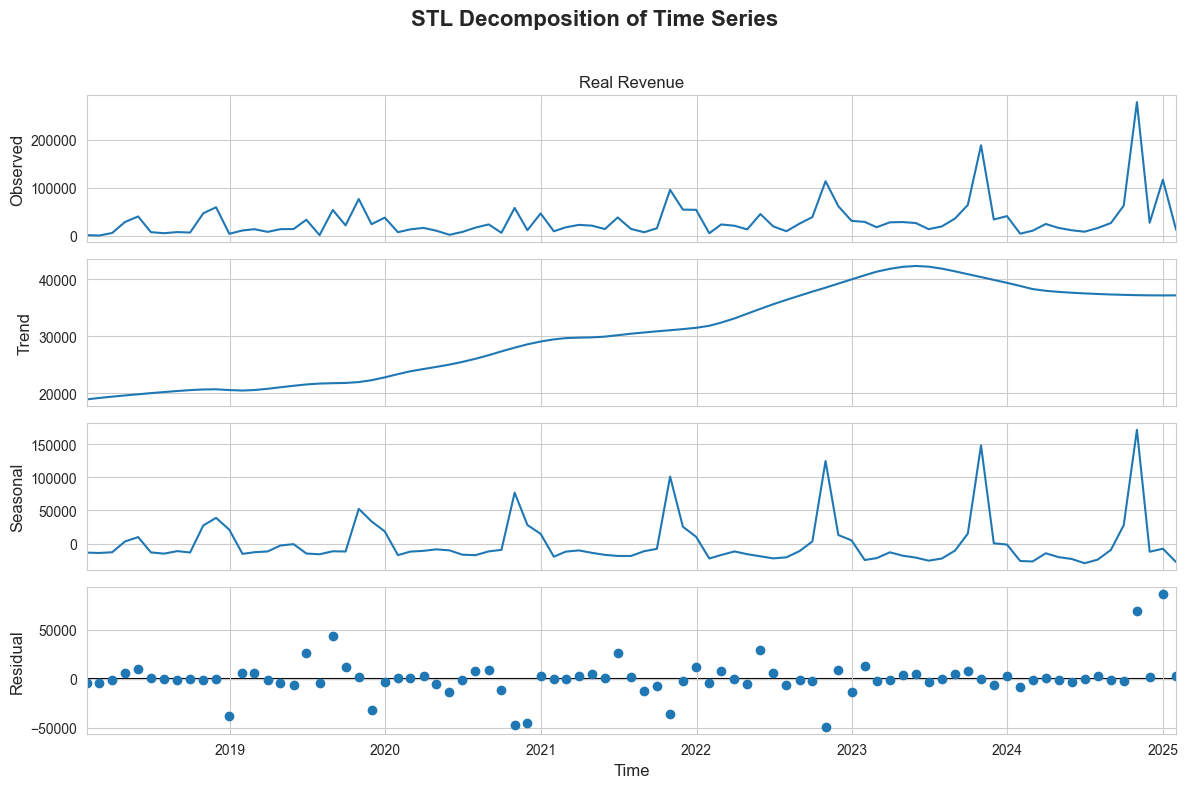

In [129]:
stl = STL(df_decomp, period= 12, robust = True)  # or 12, depending on pattern
result = stl.fit()
# Plot the STL decomposition with customizations
fig = result.plot()
fig.set_size_inches(12, 8)  # Adjust the figure size

# Add titles and labels
fig.suptitle('STL Decomposition of Time Series', fontsize=16, weight='bold')
fig.axes[0].set_ylabel('Observed', fontsize=12)
fig.axes[1].set_ylabel('Trend', fontsize=12)
fig.axes[2].set_ylabel('Seasonal', fontsize=12)
fig.axes[3].set_ylabel('Residual', fontsize=12)
fig.axes[3].set_xlabel('Time', fontsize=12)

# Improve spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

## SARIMA Forecast

In [130]:
y = df_decomp

Best SARIMA Order: (0, 0, 0)
Best Seasonal Order: (0, 1, 1, 12)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


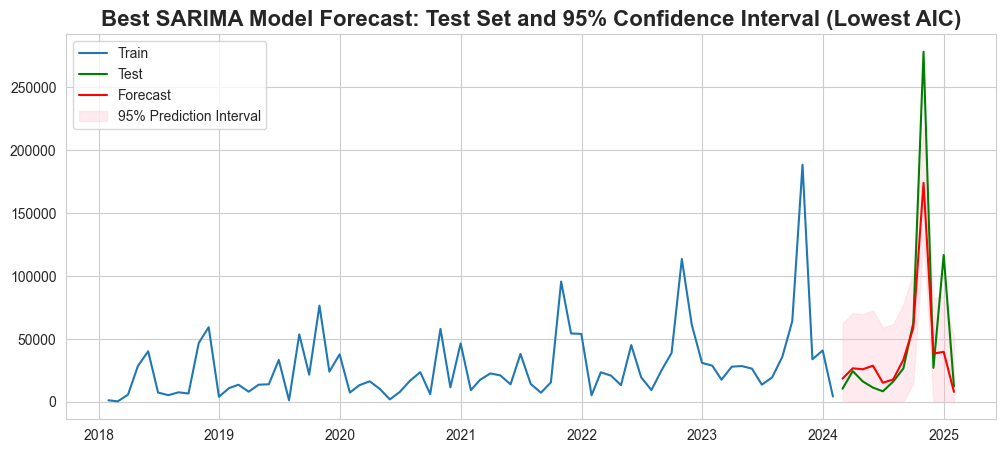

In [145]:
import warnings
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Split the data into train and test sets
train = y[:-12]
test = y[-12:]

# Use auto_arima to find the best SARIMA parameters with differencing
auto_model = auto_arima(train, 
                        seasonal=True, 
                        m=12,  # Seasonal period (e.g., 12 for monthly data)
                        d=None,  # Let auto_arima determine the order of differencing
                        D=None,  # Let auto_arima determine seasonal differencing
                        trace=False,  # Print progress
                        suppress_warnings=True, 
                        stepwise=True,  # Use stepwise search to reduce computation
                        information_criterion='aic',  # Optimize for AIC
                        test='adf',  # Use Augmented Dickey-Fuller test for stationarity
                        seasonal_test='ocsb')  # Use OCSB test for seasonal differencing

# Print the best parameters
print("Best SARIMA Order:", auto_model.order)
print("Best Seasonal Order:", auto_model.seasonal_order)

# Fit the SARIMA model using the best parameters
model = SARIMAX(train,
                order=auto_model.order,
                seasonal_order=auto_model.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=0)

# Forecast the test set
forecast = results.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Clip the confidence intervals to avoid negative values
forecast_ci.iloc[:, 0] = forecast_ci.iloc[:, 0].clip(lower=0)
forecast_ci.iloc[:, 1] = forecast_ci.iloc[:, 1].clip(lower=0)

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, forecast_values, label='Forecast', color='red')
plt.fill_between(test.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Prediction Interval')
plt.legend()
plt.title('Best SARIMA Model Forecast: Test Set and 95% Confidence Interval (Lowest AIC)', fontsize=16, weight='bold')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


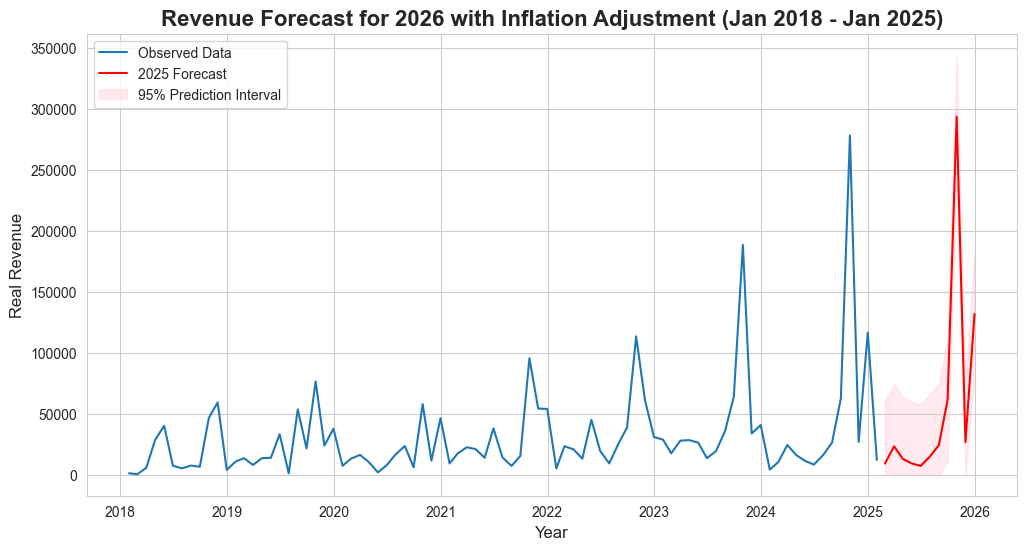

In [147]:
# Train the best SARIMA model on the full dataset
best_model = SARIMAX(y,  # Use the full dataset
                     order=auto_model.order,  # Best order from auto_arima
                     seasonal_order=auto_model.seasonal_order,  # Best seasonal order from auto_arima
                     enforce_stationarity=False,
                     enforce_invertibility=False)

best_results = best_model.fit(disp=0)

# Forecast the next 11 months
forecast_steps = 11
forecast = best_results.get_forecast(steps=forecast_steps)

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Clip the confidence intervals to avoid negative values
forecast_ci.iloc[:, 0] = forecast_ci.iloc[:, 0].clip(lower=0)
forecast_ci.iloc[:, 1] = forecast_ci.iloc[:, 1].clip(lower=0)

# Create a date range for the forecast
forecast_index = pd.date_range(start=y.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='M')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Observed Data')
plt.plot(forecast_index, forecast_values, label='2025 Forecast', color='red')
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Prediction Interval')
plt.legend(loc='upper left')
plt.title('Revenue Forecast for 2026 with Inflation Adjustment (Jan 2018 - Jan 2025)', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Real Revenue', fontsize=12)
plt.grid(True)
plt.show()

# Survival Analysis

## Choosing Threshold for Churn

count    6408.000000
mean      177.751717
std       298.672691
min         0.000000
25%        30.000000
50%        31.000000
75%       253.250000
max      3172.000000
Name: Donation_Interval, dtype: float64


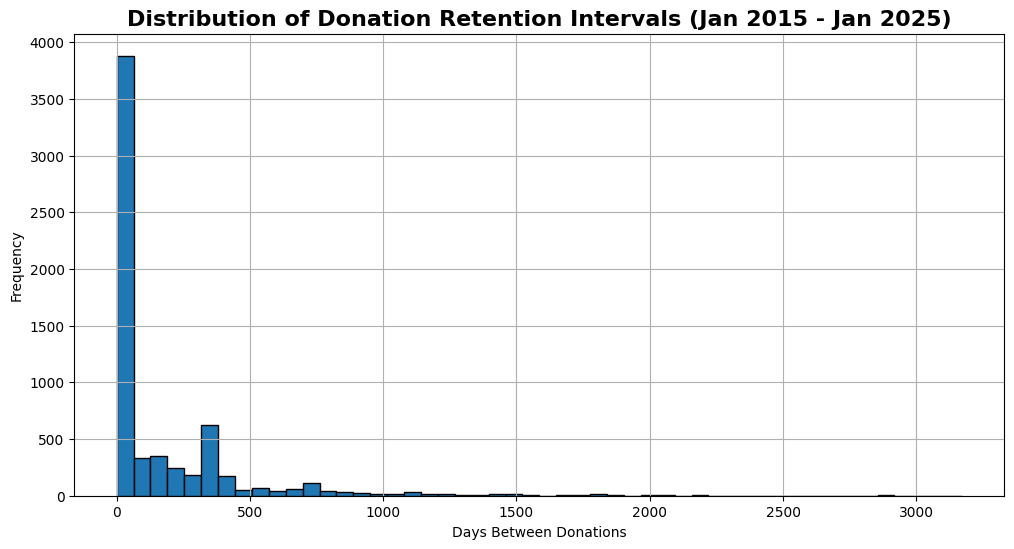

In [17]:
# Sort the data by ID and Date
df_sorted = df.sort_values(by=['ID', 'Date'])

# Calculate the time difference between consecutive donations for each donor
df_sorted['Donation_Interval'] = df_sorted.groupby('ID')['Date'].diff().dt.days

# Analyze the distribution of donation intervals
print(df_sorted['Donation_Interval'].describe())

# Plot the distribution of donation intervals
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
df_sorted['Donation_Interval'].dropna().hist(bins=50, edgecolor='black')
plt.title('Distribution of Donation Retention Intervals (Jan 2015 - Jan 2025)', fontsize=16, weight='bold')
plt.xlabel('Days Between Donations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

We can see that the data is highly skew, which mean that most donor donate within shorter intervals. However there is some extreme outlier of donator with 3172 days interval.

In [18]:
# Calculate the 65th percentile of donation intervals
churn_threshold = df_sorted['Donation_Interval'].quantile(0.65)
print(f"Churn Threshold (65th Percentile): {churn_threshold} days")

Churn Threshold (65th Percentile): 116.0 days


We set the threshold of the 65% of donation retention since we want to focus on the typical donor behavior but still accounting for the donator that donate within a reasonable time frame.

## Kaplan-Meier Visual

In [19]:
# Define 'observation_end' (your dataset cutoff date)
observation_end = pd.Timestamp('2025-01-31')

# Create a DataFrame to hold survival analysis data
df_survival = df.groupby('ID').agg(
    Last_Donation_Date=('Date', 'max'),
    First_Donation_Date=('Date', 'min'),
    Segment=('Segment', 'first') 
).reset_index()

# Compute duration (in days or months)
df_survival['Duration'] = (df_survival['Last_Donation_Date'] - df_survival['First_Donation_Date']).dt.days

# Churn definition: no donation in past 
df_survival['Churned'] = ((observation_end - df_survival['Last_Donation_Date']).dt.days > churn_threshold).astype(int)

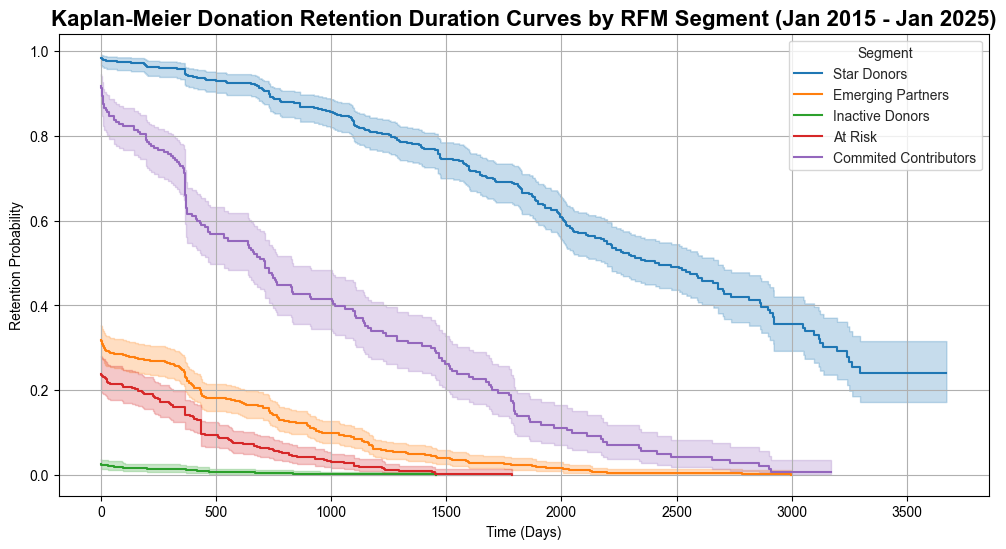

In [20]:
# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Plot survival curves for each segment
plt.figure(figsize=(12, 6))
for segment in df_survival['Segment'].unique():
    segment_data = df_survival[df_survival['Segment'] == segment]
    kmf.fit(segment_data['Duration'], event_observed=segment_data['Churned'], label=segment)
    kmf.plot_survival_function()

sns.set_style("whitegrid")
plt.title('Kaplan-Meier Donation Retention Duration Curves by RFM Segment (Jan 2015 - Jan 2025)', fontsize=16, weight='bold')
plt.xlabel('Time (Days)')
plt.ylabel('Retention Probability')
plt.legend(title = 'Segment')
plt.grid(True)
plt.show()

In [21]:
# Extract survival probabilities for each segment
summary = {}
for segment in df_survival['Segment'].unique():
    segment_data = df_survival[df_survival['Segment'] == segment]
    kmf.fit(segment_data['Duration'], event_observed=segment_data['Churned'])
    survival_table = kmf.survival_function_at_times([30, 90, 180, 365])  # Survival at 30, 90, 180, 365 days
    summary[segment] = survival_table

# Convert to a DataFrame for easier viewing
summary_df = pd.DataFrame(summary)
print(summary_df)

     Star Donors  Emerging Partners  Inactive Donors   At Risk  \
30      0.976452           0.292237         0.022069  0.217349   
90      0.974262           0.284005         0.019310  0.212048   
180     0.972068           0.273715         0.015172  0.196145   
365     0.945635           0.232555         0.012414  0.140482   

     Commited Contributors  
30                0.855552  
90                0.827191  
180               0.803557  
365               0.664614  


In [22]:
# Calculate median survival time for each segment
median_survival = {}
for segment in df_survival['Segment'].unique():
    segment_data = df_survival[df_survival['Segment'] == segment]
    kmf.fit(segment_data['Duration'], event_observed=segment_data['Churned'])
    median_survival[segment] = kmf.median_survival_time_

# Convert to a DataFrame for easier viewing
median_survival_df = pd.DataFrame(list(median_survival.items()), columns=['Segment', 'Median Survival Time'])
print(median_survival_df)

                 Segment  Median Survival Time
0            Star Donors                2408.0
1      Emerging Partners                   0.0
2        Inactive Donors                   0.0
3                At Risk                   0.0
4  Commited Contributors                 711.0


## Log Rank Test

In [23]:
from lifelines.statistics import logrank_test

# Perform log-rank test for pairwise comparison of segments
logrank_results = []
segments = df_survival['Segment'].unique()

for i in range(len(segments)):
    for j in range(i + 1, len(segments)):
        segment_1 = segments[i]
        segment_2 = segments[j]
        
        # Get data for the two segments
        data_1 = df_survival[df_survival['Segment'] == segment_1]
        data_2 = df_survival[df_survival['Segment'] == segment_2]
        
        # Perform log-rank test
        result = logrank_test(
            data_1['Duration'], data_2['Duration'],
            event_observed_A=data_1['Churned'], event_observed_B=data_2['Churned']
        )
        
        # Store the results
        logrank_results.append({
            'Segment 1': segment_1,
            'Segment 2': segment_2,
            'p-value': result.p_value
        })

# Convert results to a DataFrame for easier viewing
logrank_results_df = pd.DataFrame(logrank_results)
print(logrank_results_df)

           Segment 1              Segment 2        p-value
0        Star Donors      Emerging Partners  2.179235e-190
1        Star Donors        Inactive Donors  1.095997e-263
2        Star Donors                At Risk  8.282287e-198
3        Star Donors  Commited Contributors   3.603408e-57
4  Emerging Partners        Inactive Donors   7.076781e-50
5  Emerging Partners                At Risk   1.838977e-06
6  Emerging Partners  Commited Contributors   6.809892e-34
7    Inactive Donors                At Risk   1.953027e-23
8    Inactive Donors  Commited Contributors  1.885352e-162
9            At Risk  Commited Contributors   2.653455e-59


## Weibull AFT Summary

In [24]:
# Prepare the data for Weibull AFT regression
aft_data = df.groupby('ID').agg(
    Last_Donation_Date = ('Date', 'max'),
    First_Donation_Date = ('Date', 'min'),
    Segment=('Segment', 'first')
).reset_index()

# Compute duration (in days or months)
aft_data['Duration'] = (aft_data['Last_Donation_Date'] - aft_data['First_Donation_Date']).dt.days

# Churn definition: no donation in past 
aft_data['Churned'] = ((observation_end - aft_data['Last_Donation_Date']).dt.days > churn_threshold).astype(int)

# Convert 'Segment' to dummy variables
aft_data = pd.get_dummies(aft_data, columns=['Segment'], drop_first=True).astype(int)

# Drop unnecessary columns
aft_data = aft_data.drop(columns=['ID', 'Last_Donation_Date', 'First_Donation_Date'])

aft_data['Duration'] = aft_data['Duration'] + 0.1

In [ ]:
# Fit the Weibull AFT model
aft = WeibullAFTFitter()
aft.fit(aft_data, duration_col='Duration', event_col='Churned')

# Extract the summary as a DataFrame
summary = aft.summary

# Format and display the key metrics
print("Weibull AFT Model Summary")
print("=" * 30)
print(f"Number of Observations: {aft._n_examples}")
print(f"Number of Events Observed: {aft.event_observed.sum()}")
print(f"Log-Likelihood: {aft.log_likelihood_:.2f}")
print(f"AIC: {aft.AIC_:.2f}")
print(f"Concordance Index: {aft.concordance_index_:.2f}")
print("\nCoefficients:")
print(summary[['coef', 'exp(coef)', 'coef lower 95%', 'coef upper 95%', 'p']].to_string(index=True))

Weibull AFT Model Summary
Number of Observations: 2523
Number of Events Observed: 2146
Log-Likelihood: -6475.75
AIC: 12963.51
Concordance Index: 0.87

Coefficients:
                                           coef    exp(coef)  coef lower 95%  coef upper 95%              p
param   covariate                                                                                          
lambda_ Segment_Commited Contributors  4.705123   110.511912        4.150994        5.259252   3.452903e-62
        Segment_Emerging Partners      0.662177     1.939008        0.266414        1.057939   1.040482e-03
        Segment_Inactive Donors       -3.526680     0.029402       -3.912161       -3.141199   6.721962e-72
        Segment_Star Donors            7.707503  2224.979519        7.167786        8.247220  2.179404e-172
        Intercept                      1.973484     7.195699        1.657975        2.288992   1.495652e-34
rho_    Intercept                     -1.149509     0.316792       -1.179266   